In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generating the XOR Dataset
		according to the tensorflow playground website
	

In [2]:
def custom_xor(x,y):
	if x*y >= 0:
		return 1
	else:
		return -1
def pad_data(x):
	p = 0.3
	if x>0:
		return x+p
	else:
		return x-p
def rand_uniform(a,b):
	r = np.random.rand()
	r = r*(b-a)+a
	return r
def generate_xor_dataset(numsamples,noise=0):
	data = []
	padding = 0.3
	for i in range(numsamples):
		x = rand_uniform(-5,5)
		y = rand_uniform(-5,5)
		x = pad_data(x)
		y = pad_data(y)
		noiseX = rand_uniform(-1,1)*noise
		noiseY = rand_uniform(-1,1)*noise
		# x,y = x+noiseX,y+noiseY
		label = custom_xor(x+noiseX,y+noiseY)
		data.append([x,y,label])
	# data = np.array(data)
	return data
		

In [3]:
data_0 = generate_xor_dataset(400)

In [4]:
def plot_data(data):#Function to plot data with 2 features and 2 labels
	data = np.array(data)
	X = data[:,:2]
	y = data[:,2]
	colors = ['blue' if label == 1 else 'orange' for label in y]
	plt.scatter(X[:,0],X[:,1], c = colors,marker='.')
	plt.axhline(0, color='gray', linewidth=1, linestyle='-')  # X-axis line at y=0
	plt.axvline(0, color='gray', linewidth=1, linestyle='-')  # Y-axis line at x=0
	plt.show()

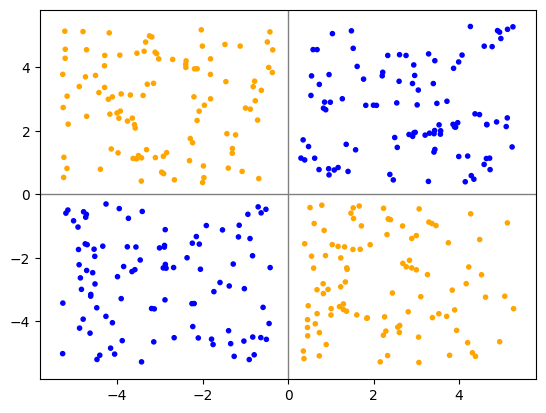

In [5]:
plot_data(data_0)

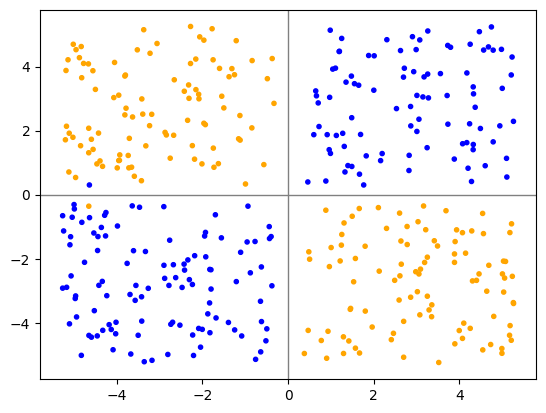

In [6]:
data_05 = generate_xor_dataset(400,0.5)
plot_data(data_05)

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
# Data Generation
data = generate_xor_dataset(4000,5)  # 200 train + 200 test
data = np.array(data)
X, y = data[:, :2], data[:, 2]
y = (y > 0).astype(int)  # Convert labels to binary (1 for positive, 0 for negative)

# Split data into training, validation, and test sets manually
def split_data(X, y, train_size=0.6, val_size=0.2):
	total_samples = len(X)
	train_end = int(train_size * total_samples)
	val_end = int((train_size + val_size) * total_samples)

	X_train, y_train = torch.tensor(X[:train_end], dtype=torch.float32), torch.tensor(y[:train_end], dtype=torch.float32)
	X_val, y_val = torch.tensor(X[train_end:val_end], dtype=torch.float32), torch.tensor(y[train_end:val_end], dtype=torch.float32)
	X_test, y_test = torch.tensor(X[val_end:], dtype=torch.float32), torch.tensor(y[val_end:], dtype=torch.float32)

	return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
						 np.arange(y_min, y_max, 0.1))
	grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
	Z = model(grid).detach().numpy().reshape(xx.shape)
	plt.contourf(xx, yy, Z, alpha=0.8)
	plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
	plt.title(title)
	plt.show()

# Define MLP Model with optional L1 and L2 regularization
class MLP(nn.Module):
	def __init__(self, l1=0, l2=0):
		super(MLP, self).__init__()
		self.fc1 = nn.Linear(2, 10)
		self.fc2 = nn.Linear(10, 10)
		self.fc3 = nn.Linear(10, 1)
		self.l1 = l1
		self.l2 = l2

	def forward(self, x):
		x = torch.relu(self.fc1(x))
		x = torch.relu(self.fc2(x))
		x = torch.sigmoid(self.fc3(x))
		return x

	def regularization_loss(self):
		l1_loss = self.l1 * (torch.norm(self.fc1.weight, 1) + torch.norm(self.fc2.weight, 1) + torch.norm(self.fc3.weight, 1))
		l2_loss = self.l2 * (torch.norm(self.fc1.weight, 2) + torch.norm(self.fc2.weight, 2) + torch.norm(self.fc3.weight, 2))
		return l1_loss + l2_loss


In [9]:
# Training function
def train_model(model, X_train, y_train, X_val, y_val, epochs=400):
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	criterion = nn.BCELoss()

	for epoch in range(epochs):
		model.train()
		optimizer.zero_grad()
		output = model(X_train).squeeze()
		loss = criterion(output, y_train) + model.regularization_loss()
		loss.backward()
		optimizer.step()

		if epoch % 10 == 0:
			model.eval()
			val_output = model(X_val).squeeze()
			val_loss = criterion(val_output, y_val)
			print(f'Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')



Epoch 0, Loss: 0.7046900391578674, Val Loss: 0.6940743327140808
Epoch 10, Loss: 0.6314890384674072, Val Loss: 0.6412680149078369
Epoch 20, Loss: 0.6139895915985107, Val Loss: 0.614525556564331
Epoch 30, Loss: 0.6114742755889893, Val Loss: 0.6184185743331909
Epoch 40, Loss: 0.6091368794441223, Val Loss: 0.6191808581352234
Epoch 50, Loss: 0.6076835989952087, Val Loss: 0.6173012256622314
Epoch 60, Loss: 0.6066781282424927, Val Loss: 0.6169325113296509
Epoch 70, Loss: 0.6058764457702637, Val Loss: 0.616976261138916
Epoch 80, Loss: 0.6052716970443726, Val Loss: 0.6170972585678101
Epoch 90, Loss: 0.6047850251197815, Val Loss: 0.6169921159744263
Epoch 100, Loss: 0.6043034195899963, Val Loss: 0.6164004802703857
Epoch 110, Loss: 0.6038585901260376, Val Loss: 0.6157233715057373
Epoch 120, Loss: 0.6034056544303894, Val Loss: 0.6154910922050476
Epoch 130, Loss: 0.6029121279716492, Val Loss: 0.6152152419090271
Epoch 140, Loss: 0.602419376373291, Val Loss: 0.614851713180542
Epoch 150, Loss: 0.601890

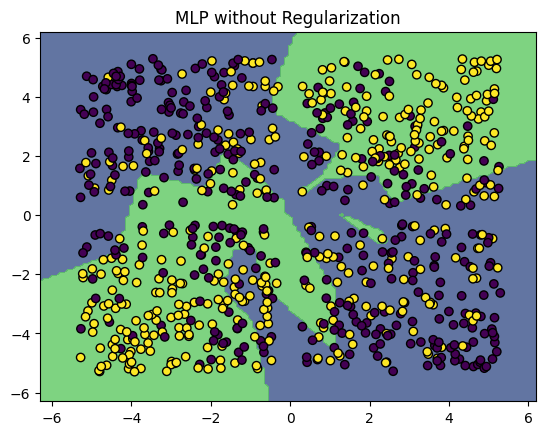

In [10]:
# MLP without Regularization
model_mlp = MLP()
train_model(model_mlp, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_mlp(x).squeeze() > 0.5, X_test, y_test, "MLP without Regularization")


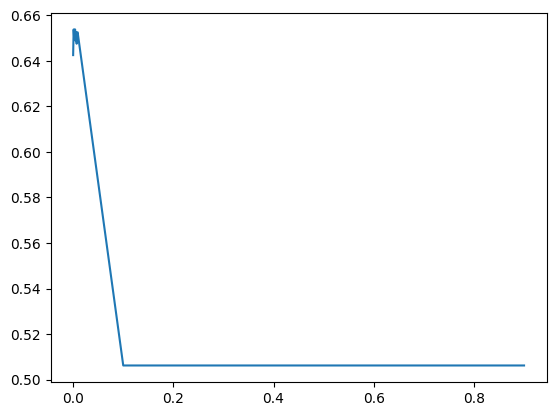

Best Penalty Coefficient: 0.001,	 Best Validation Accuracy: 0.6538



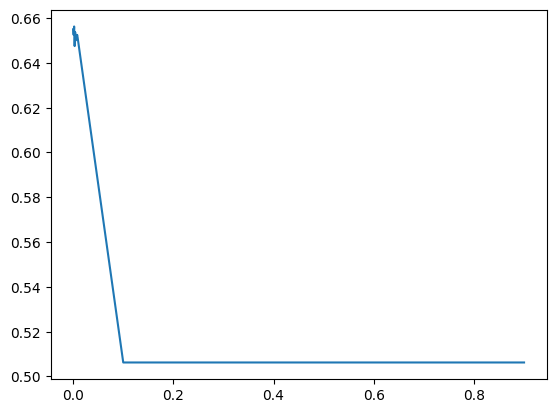

Best Penalty Coefficient: 0.002,	 Best Validation Accuracy: 0.6562


In [11]:
def evaluate_model(model, X_val, y_val):
	model.eval()
	with torch.no_grad():
		predictions = (model(X_val).squeeze() > 0.5).float()
		accuracy = (predictions == y_val).float().mean().item()
	return accuracy

# Function to train the model with a given L1 or L2 penalty coefficient
def train_with_penalty(X_train, y_train, X_val, y_val, penalty_coefficient, l1=False, l2=False, epochs=400):
	if l1:
		model = MLP(l1=penalty_coefficient)
	elif l2:
		model = MLP(l2=penalty_coefficient)
	
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	criterion = nn.BCELoss()

	for epoch in range(epochs):
		model.train()
		optimizer.zero_grad()
		output = model(X_train).squeeze()
		loss = criterion(output, y_train) + model.regularization_loss()
		loss.backward()
		optimizer.step()
	
	# Evaluate on validation data
	accuracy = evaluate_model(model, X_val, y_val)
	return accuracy, model

# Grid Search for Best L1/L2 Penalty Coefficient
def find_best_penalty(X_train, y_train, X_val, y_val, penalty_range, l1=False, l2=False):
	best_accuracy = 0.0
	best_coefficient = None
	best_model = None
	penalties = []
	accs = []

	for coefficient in penalty_range:
		accuracy, model = train_with_penalty(X_train, y_train, X_val, y_val, coefficient, l1=l1, l2=l2)
		# print(f"Penalty Coefficient: {coefficient},\t Validation Accuracy: {accuracy:.4f}")
		penalties.append(coefficient)
		accs.append(accuracy)
		
		if accuracy > best_accuracy:
			best_accuracy = accuracy
			best_coefficient = coefficient
			best_model = model
	plt.plot(penalties, accs, label = "penality vs Validation accuracy")
	plt.show()

	print(f"Best Penalty Coefficient: {best_coefficient},\t Best Validation Accuracy: {best_accuracy:.4f}")
	return best_coefficient, best_model

# Define a range of penalty coefficients to test
penalty_range = list(np.arange(0, 1,0.1))+list(np.arange(0.001,0.01,0.001))
# penalty_range = np.arange(0.001,0.01,0.001)
penalty_range.sort()
# Find the best L1 penalty coefficient
best_l1_penalty, best_l1_model = find_best_penalty(X_train, y_train, X_val, y_val, penalty_range, l1=True)
print()
# print()
# Find the best L2 penalty coefficient
best_l2_penalty, best_l2_model = find_best_penalty(X_train, y_train, X_val, y_val, penalty_range, l2=True)

Epoch 0, Loss: 0.7221012115478516, Val Loss: 0.6828340888023376
Epoch 10, Loss: 0.6516038775444031, Val Loss: 0.6269878149032593
Epoch 20, Loss: 0.6388411521911621, Val Loss: 0.6195780038833618
Epoch 30, Loss: 0.630457878112793, Val Loss: 0.6148842573165894
Epoch 40, Loss: 0.6269828081130981, Val Loss: 0.6132428646087646
Epoch 50, Loss: 0.6251177191734314, Val Loss: 0.6142182946205139
Epoch 60, Loss: 0.6239614486694336, Val Loss: 0.613494873046875
Epoch 70, Loss: 0.622855544090271, Val Loss: 0.6133310794830322
Epoch 80, Loss: 0.621902585029602, Val Loss: 0.6132367849349976
Epoch 90, Loss: 0.6207190155982971, Val Loss: 0.6128360629081726
Epoch 100, Loss: 0.6194854378700256, Val Loss: 0.6133891344070435
Epoch 110, Loss: 0.6186806559562683, Val Loss: 0.6140500903129578
Epoch 120, Loss: 0.6181585192680359, Val Loss: 0.6141824126243591
Epoch 130, Loss: 0.6177481412887573, Val Loss: 0.6144885420799255
Epoch 140, Loss: 0.6173598170280457, Val Loss: 0.6146227717399597
Epoch 150, Loss: 0.617037

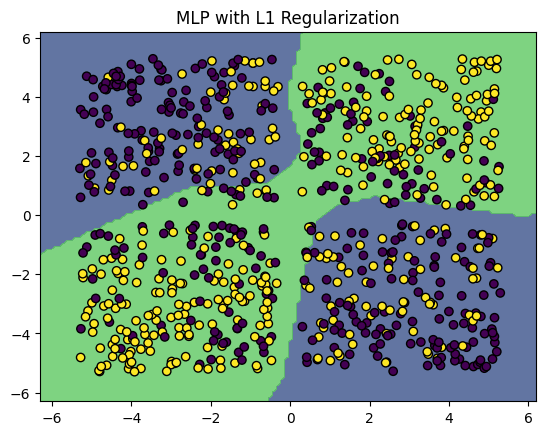

In [12]:
# MLP with L1 Regularization
# best_l1_penalty = 0.01  # Adjust based on experimentation
model_l1 = MLP(l1=best_l1_penalty)
train_model(model_l1, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_l1(x).squeeze() > 0.5, X_test, y_test, "MLP with L1 Regularization")



Epoch 0, Loss: 0.7033477425575256, Val Loss: 0.6882885098457336
Epoch 10, Loss: 0.6589292883872986, Val Loss: 0.6519529223442078
Epoch 20, Loss: 0.6276488304138184, Val Loss: 0.6273863911628723
Epoch 30, Loss: 0.6213901042938232, Val Loss: 0.6153411269187927
Epoch 40, Loss: 0.6182180047035217, Val Loss: 0.6207702159881592
Epoch 50, Loss: 0.6168991923332214, Val Loss: 0.6184250712394714
Epoch 60, Loss: 0.6159669756889343, Val Loss: 0.6162717938423157
Epoch 70, Loss: 0.6153848767280579, Val Loss: 0.6151649951934814
Epoch 80, Loss: 0.6147416830062866, Val Loss: 0.6146272420883179
Epoch 90, Loss: 0.6142564415931702, Val Loss: 0.6138741970062256
Epoch 100, Loss: 0.6138540506362915, Val Loss: 0.613781750202179
Epoch 110, Loss: 0.6135078072547913, Val Loss: 0.6136874556541443
Epoch 120, Loss: 0.6131283640861511, Val Loss: 0.6130080819129944
Epoch 130, Loss: 0.6127732396125793, Val Loss: 0.6125755906105042
Epoch 140, Loss: 0.6123539209365845, Val Loss: 0.6121354103088379
Epoch 150, Loss: 0.611

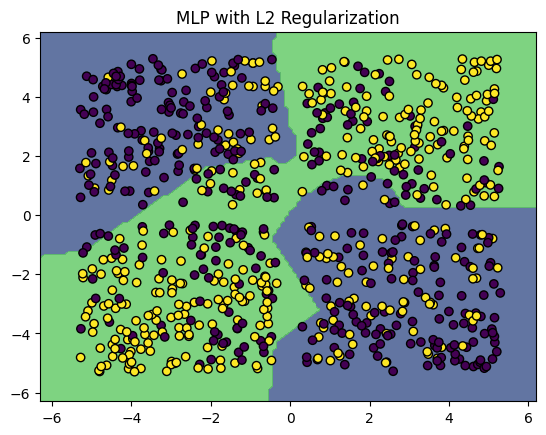

In [13]:
# MLP with L2 Regularization
# best_l2_penalty = 0.01  # Adjust based on experimentation
model_l2 = MLP(l2=best_l2_penalty)
train_model(model_l2, X_train, y_train, X_val, y_val)
plot_decision_boundary(lambda x: model_l2(x).squeeze() > 0.5, X_test, y_test, "MLP with L2 Regularization")



Epoch 0, Loss: 1.0448009967803955
Epoch 50, Loss: 0.6435593962669373
Epoch 100, Loss: 0.6109458804130554
Epoch 150, Loss: 0.6052343249320984
Epoch 200, Loss: 0.6043238639831543
Epoch 250, Loss: 0.604159414768219
Epoch 300, Loss: 0.6041095852851868
Epoch 350, Loss: 0.6040785312652588


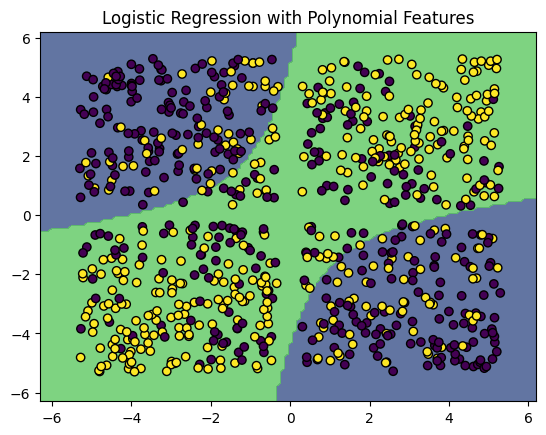

In [14]:
class LogisticRegressionModel(nn.Module):
	def __init__(self, input_dim):
		super(LogisticRegressionModel, self).__init__()
		self.linear = nn.Linear(input_dim, 1)

	def forward(self, x):
		return torch.sigmoid(self.linear(x))

# Manual polynomial feature expansion
def polynomial_features(X, degree=2):
	poly_features = [X]  # Start with original features

	for d in range(2, degree + 1):
		for i in range(d + 1):
			feature = (X[:, 0]**(d - i)) * (X[:, 1]**i)
			poly_features.append(feature.view(-1, 1))  # Reshape to [240, 1]

	return torch.cat(poly_features, dim=1)  # Concatenate along the second dimension

X_poly_train = polynomial_features(X_train, degree=2)
X_poly_test = polynomial_features(X_test, degree=2)

log_reg = LogisticRegressionModel(X_poly_train.shape[1])
optimizer = optim.SGD(log_reg.parameters(), lr=0.01)
criterion = nn.BCELoss()

# Training Logistic Regression
for epoch in range(400):
	log_reg.train()
	optimizer.zero_grad()
	output = log_reg(X_poly_train).squeeze()
	loss = criterion(output, y_train)
	loss.backward()
	optimizer.step()
	if epoch % 50 == 0:
		print(f'Epoch {epoch}, Loss: {loss.item()}')

# Plot decision boundary for Logistic Regression with polynomial features
plot_decision_boundary(lambda x: log_reg(polynomial_features(x)).squeeze() > 0.5, X_test, y_test, "Logistic Regression with Polynomial Features")


Model: MLP without Regularization
Accuracy: 0.67
Precision: 0.67
Recall: 0.65
F1 Score: 0.658974358974359
Confusion Matrix:
[[277 126]
 [140 257]]


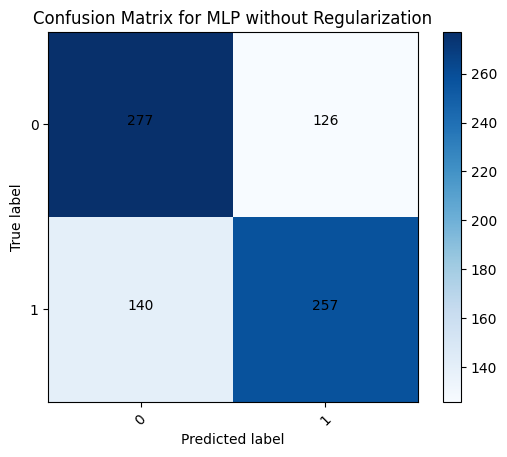


Model: MLP with L1 Regularization
Accuracy: 0.67
Precision: 0.65
Recall: 0.70
F1 Score: 0.6747868453105969
Confusion Matrix:
[[256 147]
 [120 277]]


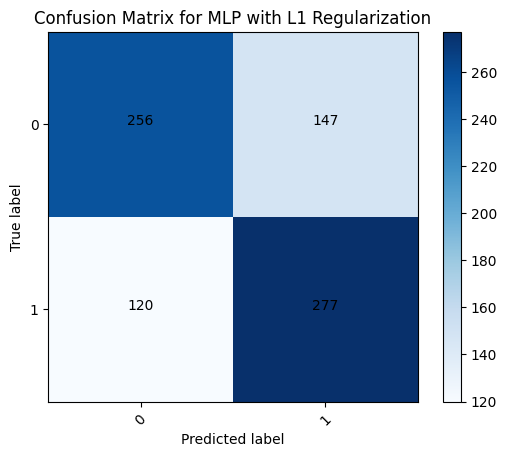


Model: MLP with L2 Regularization
Accuracy: 0.68
Precision: 0.66
Recall: 0.70
F1 Score: 0.6821515892420538
Confusion Matrix:
[[261 142]
 [118 279]]


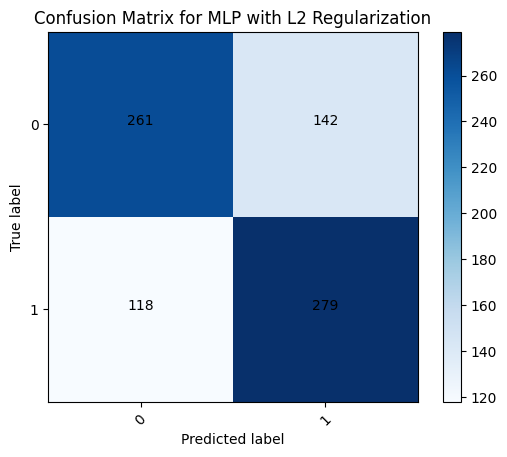


Model: Logistic Regression with Polynomial Features
Accuracy: 0.67
Precision: 0.64
Recall: 0.73
F1 Score: 0.6855123674911661
Confusion Matrix:
[[242 161]
 [106 291]]


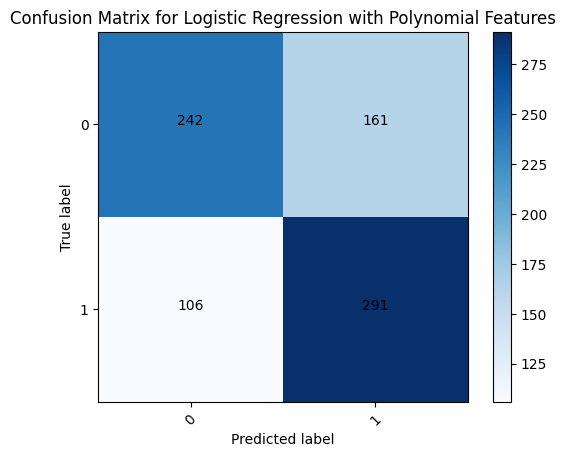

In [16]:
# Function to compute metrics: accuracy, precision, recall, and confusion matrix
# Compute metrics function, updated to handle polynomial features for Logistic Regression
def compute_metrics(model, X, y, poly_features=False):
	model.eval()
	with torch.no_grad():
		# If polynomial features are needed, expand X
		if poly_features:
			X = polynomial_features(X, degree=2)
		
		# Predict
		predictions = (model(X).squeeze() > 0.5).float()
		
		# Calculate confusion matrix components
		tp = ((predictions == 1) & (y == 1)).sum().item()  # True Positive
		tn = ((predictions == 0) & (y == 0)).sum().item()  # True Negative
		fp = ((predictions == 1) & (y == 0)).sum().item()  # False Positive
		fn = ((predictions == 0) & (y == 1)).sum().item()  # False Negative

		# Calculate accuracy, precision, recall
		accuracy = (tp + tn) / (tp + tn + fp + fn)
		precision = tp / (tp + fp) if (tp + fp) > 0 else 0
		recall = tp / (tp + fn) if (tp + fn) > 0 else 0
		f1_score = (2*tp)/((2*tp)+fn+fp)

		# Create confusion matrix
		confusion_matrix = np.array([[tn, fp], [fn, tp]])

	return accuracy, precision, recall,f1_score, confusion_matrix


# Function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, title):
	plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(2)
	plt.xticks(tick_marks, ["0", "1"], rotation=45)
	plt.yticks(tick_marks, ["0", "1"])

	plt.xlabel("Predicted label")
	plt.ylabel("True label")

	# Adding values to the confusion matrix plot
	for i in range(2):
		for j in range(2):
			plt.text(j, i, f"{confusion_matrix[i, j]}", horizontalalignment="center")

	plt.show()

# Evaluate and print metrics for each model
models = {
	"MLP without Regularization": model_mlp,
	"MLP with L1 Regularization": model_l1,
	"MLP with L2 Regularization": model_l2,
	"Logistic Regression with Polynomial Features": log_reg
}

for name, model in models.items():
	if "Logistic Regression" in name:
		accuracy, precision, recall,f1_score, confusion_matrix = compute_metrics(model, X_test, y_test, poly_features=True)
	else:
		accuracy, precision, recall,f1_score, confusion_matrix = compute_metrics(model, X_test, y_test)

	print(f"\nModel: {name}")
	print(f"Accuracy: {accuracy:.2f}")
	print(f"Precision: {precision:.2f}")
	print(f"Recall: {recall:.2f}")
	print(f"F1 Score: {f1_score}")
	print("Confusion Matrix:")
	print(confusion_matrix)
	
	# Plot confusion matrix
	plot_confusion_matrix(confusion_matrix, title=f"Confusion Matrix for {name}")
